In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
data= pd.read_csv('/content/drive/MyDrive/CSE All-Share Historical Data.csv')

In [ ]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,7/11/2019,"5,561.28","5,523.95","5,563.32","5,521.83",23.64M,0.71%
1,7/12/2019,"5,569.94","5,557.64","5,578.84","5,551.48",13.44M,0.16%
2,7/15/2019,"5,587.36","5,567.68","5,590.86","5,565.63",2.64B,0.31%
3,7/17/2019,"5,645.65","5,587.88","5,651.73","5,587.36",35.34M,1.04%
4,7/18/2019,"5,695.69","5,647.98","5,699.26","5,645.65",51.95M,0.89%


In [ ]:
data["Price"] = data["Price"].str.replace(",", "").astype(float)

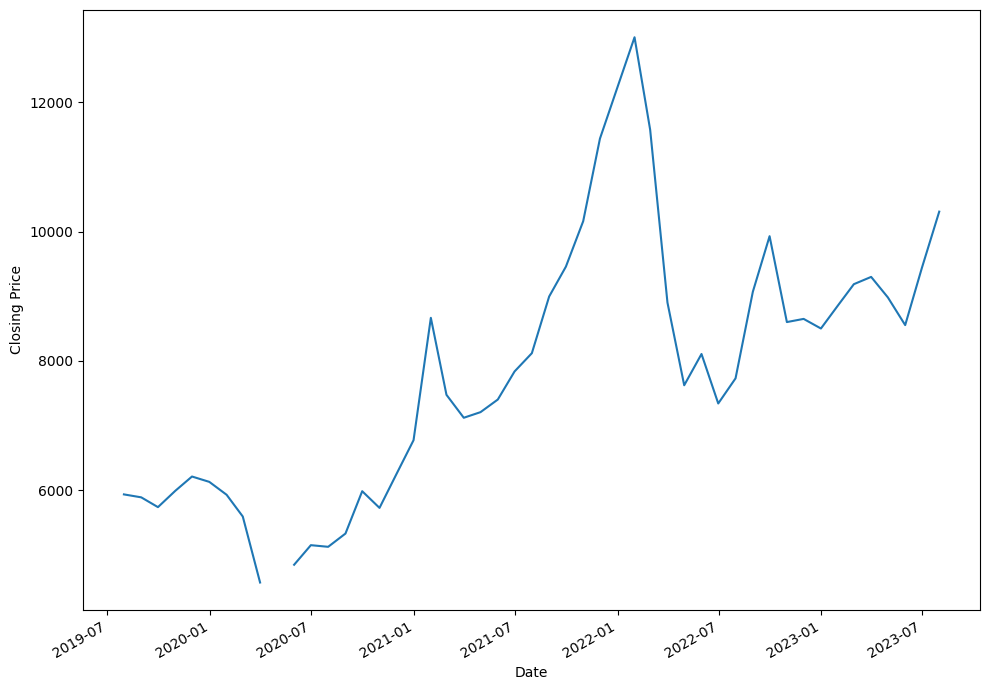

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Resample data on a monthly basis
monthly_data = data.resample('M', on='Date').last()

ax.plot(monthly_data.index, monthly_data['Price'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

#Predict next step using last observation

In [ ]:
data.head()df = data.copy()

,Date,Price
0,2019-07-11,5561.28
1,2019-07-12,5569.94
2,2019-07-15,5587.36
3,2019-07-17,5645.65
4,2019-07-18,5695.69


In [ ]:
#format the dataset so current observation is a feature to predict the next observation (the target), shift(-1) adds a second column that simply shifts price column
df = data.copy()

df['y'] = df['Price'].shift(-1)
df

,Date,Price,y
0,2019-07-11,5561.28,5569.94
1,2019-07-12,5569.94,5587.36
2,2019-07-15,5587.36,5645.65
3,2019-07-17,5645.65,5695.69
4,2019-07-18,5695.69,5715.14
...,...,...,...
915,2023-07-04,10120.26,10176.13
916,2023-07-05,10176.13,10224.80
917,2023-07-06,10224.80,10309.15
918,2023-07-07,10309.15,10311.25


In [ ]:
#Using last 2 years for the training set. Since we have weekly data, and there are 52 weeks in a year, it means that the last 104 samples are kept for the test set.
train = df[:-104]
test = df[-104:]
test = test.drop(test.tail(1).index) # Drop last row
print(f'Shape of training set: {train.shape}')
print(f'Shape of test set: {test.shape}')

Shape of training set: (816, 3)
Shape of test set: (103, 3)


##Baseline model: repeat last observation

In [ ]:
#baseline model to determine if using machine learning models is better, predict that the next observation will have the same value as the current observation
test = test.copy()
test['baseline_pred'] = test['Price']
test

,Date,Price,y,baseline_pred
816,2023-02-01,8977.09,9022.38,8977.09
817,2023-02-02,9022.38,9178.61,9022.38
818,2023-02-03,9178.61,9100.14,9178.61
819,2023-02-06,9100.14,8999.75,9100.14
820,2023-02-07,8999.75,8987.45,8999.75
...,...,...,...,...
914,2023-06-28,9442.95,10120.26,9442.95
915,2023-07-04,10120.26,10176.13,10120.26
916,2023-07-05,10176.13,10224.80,10176.13
917,2023-07-06,10224.80,10309.15,10224.80


##Apply decision tree (Can be replaced by other regressors)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

#.reshape(-1,1) the code is transforming the 'Price' column values from a 1-dimensional array to a 2-dimensional array with a single column
#-1 indicates to NumPy that it should calculate the appropriate number of rows based on the size of the array and the specified column dimension (which is 1 in this case).
X_train = train['Price'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['Price'].values.reshape(-1,1)

# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_reg.fit(X=X_train, y=y_train)

# Make predictions
dt_pred = dt_reg.predict(X_test)

# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

test

,Date,Price,y,baseline_pred,dt_pred
816,2023-02-01,8977.09,9022.38,8977.09,9087.59
817,2023-02-02,9022.38,9178.61,9022.38,9191.52
818,2023-02-03,9178.61,9100.14,9178.61,9049.52
819,2023-02-06,9100.14,8999.75,9100.14,8990.72
820,2023-02-07,8999.75,8987.45,8999.75,9163.13
...,...,...,...,...,...
914,2023-06-28,9442.95,10120.26,9442.95,9542.33
915,2023-07-04,10120.26,10176.13,10120.26,10146.90
916,2023-07-05,10176.13,10224.80,10176.13,10856.07
917,2023-07-06,10224.80,10309.15,10224.80,10353.83


In [ ]:
#mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [ ]:
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])

print(f'Baseline: {baseline_mape}%')
print(f'Decision Tree: {dt_mape}%')

Baseline: 0.8%
Decision Tree: 1.61%


##Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y=y_train.ravel())

gbr_pred = gbr.predict(X_test)

test['gbr_pred'] = gbr_pred

test

,Date,Price,y,baseline_pred,dt_pred,gbr_pred
816,2023-02-01,8977.09,9022.38,8977.09,9087.59,8995.505706
817,2023-02-02,9022.38,9178.61,9022.38,9191.52,8995.505706
818,2023-02-03,9178.61,9100.14,9178.61,9049.52,9133.595945
819,2023-02-06,9100.14,8999.75,9100.14,8990.72,8997.356526
820,2023-02-07,8999.75,8987.45,8999.75,9163.13,8995.505706
...,...,...,...,...,...,...
914,2023-06-28,9442.95,10120.26,9442.95,9542.33,9546.905001
915,2023-07-04,10120.26,10176.13,10120.26,10146.90,10085.254360
916,2023-07-05,10176.13,10224.80,10176.13,10856.07,10509.002793
917,2023-07-06,10224.80,10309.15,10224.80,10353.83,10420.145631


In [ ]:
gbr_mape = mape(test['y'], test['gbr_pred'])

print(f'Gradient Boosting Regressor: {gbr_mape}%')

Gradient Boosting Regressor: 1.0%


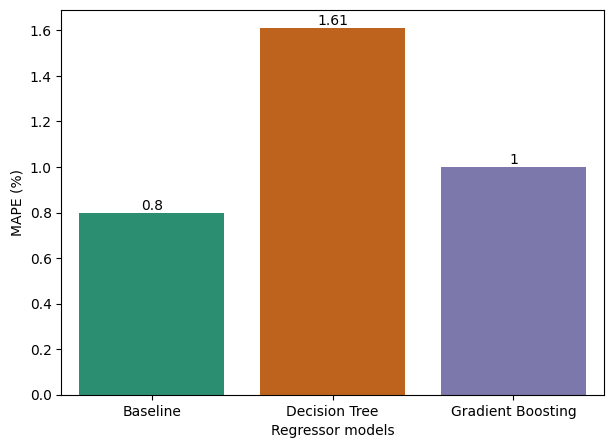

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
plot2=sns.barplot(data=df,x=['Baseline', 'Decision Tree', 'Gradient Boosting'],y=[baseline_mape, dt_mape, gbr_mape],palette="Dark2")
plot2.bar_label(plot2.containers[0]);

# baseline has the best performance, since it has the lowest MAPE

#Predict the next time step using a sequence of past observations

In [ ]:
data

,Date,Price
0,2019-07-11,5561.28
1,2019-07-12,5569.94
2,2019-07-15,5587.36
3,2019-07-17,5645.65
4,2019-07-18,5695.69
...,...,...
915,2023-07-04,10120.26
916,2023-07-05,10176.13
917,2023-07-06,10224.80
918,2023-07-07,10309.15


In [ ]:
#format our dataset such that we have a sequence of past observations acting as predictors to the following time step, adds shifted column
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:

    df = data.copy()

    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['Price'].shift(-i)
        i = i + 1

    if i == window_length:
        df['y'] = df['Price'].shift(-i)

    # Drop rows where there is a NaN
    df = df.dropna(axis=0)

    return df

In [ ]:
#have an input of 5 observations in order to predict the next time step
new_df = window_input(5, data)
new_df

,Date,Price,x_1,x_2,x_3,x_4,y
0,2019-07-11,5561.28,5569.94,5587.36,5645.65,5695.69,5715.14
1,2019-07-12,5569.94,5587.36,5645.65,5695.69,5715.14,5659.77
2,2019-07-15,5587.36,5645.65,5695.69,5715.14,5659.77,5683.47
3,2019-07-17,5645.65,5695.69,5715.14,5659.77,5683.47,5745.97
4,2019-07-18,5695.69,5715.14,5659.77,5683.47,5745.97,5794.66
...,...,...,...,...,...,...,...
910,2023-06-22,9307.87,9339.43,9476.69,9370.51,9442.95,10120.26
911,2023-06-23,9339.43,9476.69,9370.51,9442.95,10120.26,10176.13
912,2023-06-26,9476.69,9370.51,9442.95,10120.26,10176.13,10224.80
913,2023-06-27,9370.51,9442.95,10120.26,10176.13,10224.80,10309.15


In [ ]:
from sklearn.model_selection import train_test_split

X = new_df[['Price', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [ ]:
#predicting the mean of the input sequence
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

##Decision Tree Regressor and Gradient Boosting

In [ ]:
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(X_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(X_test)

In [ ]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

In [ ]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)

print(f'Baseline MAPE: {baseline_mape}%')
print(f'Decision Tree MAPE: {dt_5_mape}%')
print(f'Gradient Boosting MAPE: {gbr_5_mape}%')

Baseline MAPE: 1.83%
Decision Tree MAPE: 2.14%
Gradient Boosting MAPE: 1.28%


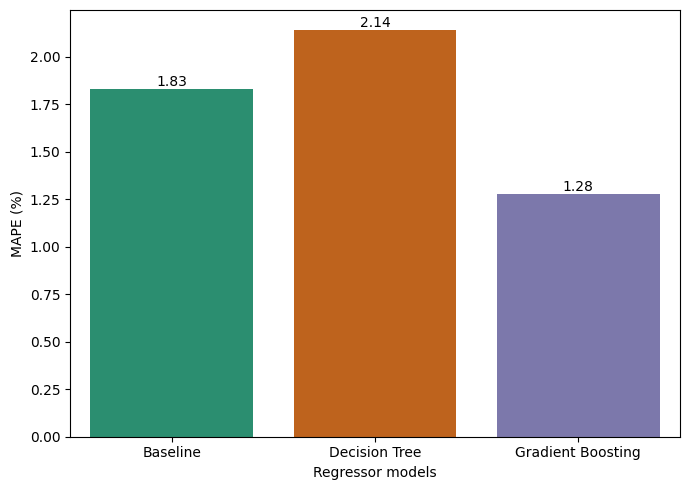

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
plot2=sns.barplot(data=df,x=['Baseline', 'Decision Tree', 'Gradient Boosting'],y=[baseline_mape, dt_5_mape, gbr_5_mape],palette="Dark2")
plot2.bar_label(plot2.containers[0]);
plt.tight_layout()
# Gradient Boosting has the best performance, since it has the lowest MAPE

##Predict a sequence of future time steps using a sequence of past observations

In [ ]:
#develop another function that uses the shift method to format the dataset as a multi-output regression problem
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:

    df = data.copy()

    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['Price'].shift(-i)
        i = i + 1

    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['Price'].shift(-output_length-j)
        j = j + 1

    df = df.dropna(axis=0)

    return df

In [ ]:
#use a sequence of 26 observations to predict the next 26 time steps. In other words, we input half of a year to predict the next half
seq_df = window_input_output(26, 26, data)

In [ ]:
#have a dataset where 26 observations are used as predictors for the next 26 time steps
seq_df

,Date,Price,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25
0,2019-07-11,5561.28,5569.94,5587.36,5645.65,5695.69,5715.14,5659.77,5683.47,5745.97,...,5825.54,5828.14,5811.07,5807.51,5811.04,5793.89,5776.48,5743.54,5762.40,5772.76
1,2019-07-12,5569.94,5587.36,5645.65,5695.69,5715.14,5659.77,5683.47,5745.97,5794.66,...,5828.14,5811.07,5807.51,5811.04,5793.89,5776.48,5743.54,5762.40,5772.76,5771.69
2,2019-07-15,5587.36,5645.65,5695.69,5715.14,5659.77,5683.47,5745.97,5794.66,5872.89,...,5811.07,5807.51,5811.04,5793.89,5776.48,5743.54,5762.40,5772.76,5771.69,5738.24
3,2019-07-17,5645.65,5695.69,5715.14,5659.77,5683.47,5745.97,5794.66,5872.89,5995.20,...,5807.51,5811.04,5793.89,5776.48,5743.54,5762.40,5772.76,5771.69,5738.24,5733.64
4,2019-07-18,5695.69,5715.14,5659.77,5683.47,5745.97,5794.66,5872.89,5995.20,5951.75,...,5811.04,5793.89,5776.48,5743.54,5762.40,5772.76,5771.69,5738.24,5733.64,5697.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,2023-04-17,9405.90,9345.53,9291.42,9279.19,9260.41,9187.29,9125.32,9091.72,9012.40,...,9248.56,9181.22,9159.53,9295.40,9307.87,9339.43,9476.69,9370.51,9442.95,10120.26
865,2023-04-18,9345.53,9291.42,9279.19,9260.41,9187.29,9125.32,9091.72,9012.40,8983.21,...,9181.22,9159.53,9295.40,9307.87,9339.43,9476.69,9370.51,9442.95,10120.26,10176.13
866,2023-04-19,9291.42,9279.19,9260.41,9187.29,9125.32,9091.72,9012.40,8983.21,8711.46,...,9159.53,9295.40,9307.87,9339.43,9476.69,9370.51,9442.95,10120.26,10176.13,10224.80
867,2023-04-20,9279.19,9260.41,9187.29,9125.32,9091.72,9012.40,8983.21,8711.46,8799.91,...,9295.40,9307.87,9339.43,9476.69,9370.51,9442.95,10120.26,10176.13,10224.80,10309.15


In [ ]:
#[:-2] -> reserves the last two rows for the test set, as it gives us 52 test samples.
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'Price')

y_cols = [col for col in seq_df.columns if col.startswith('y')]
X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

##Decision Tree, Gradient Boosting and Baseline

In [ ]:
dt_seq = DecisionTreeRegressor(random_state=42)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)

In [ ]:
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

In [ ]:
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_baseline = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))

In [ ]:
print(f'Baseline MAPE: {mape_baseline}%')
print(f'Decision Tree MAPE: {mape_dt_seq}%')
print(f'Gradient Boosting MAPE: {mape_gbr_seq}%')

Baseline MAPE: 6.78%
Decision Tree MAPE: 5.63%
Gradient Boosting MAPE: 8.55%


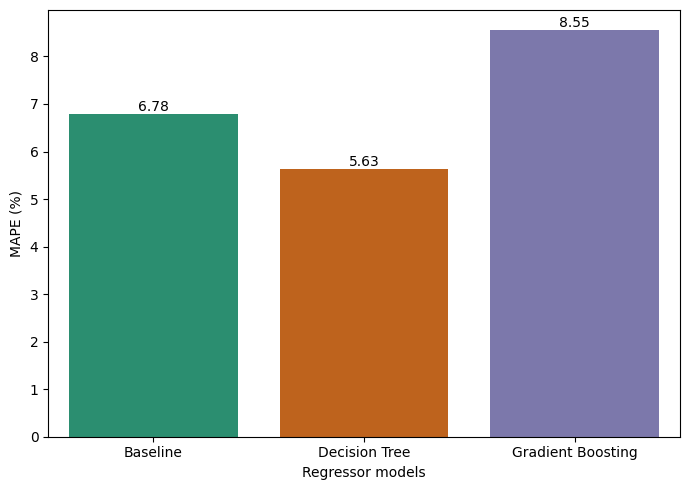

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
plot2=sns.barplot(data=df,x=['Baseline', 'Decision Tree', 'Gradient Boosting'],y=[mape_baseline, mape_dt_seq, mape_gbr_seq],palette="Dark2")
plot2.bar_label(plot2.containers[0]);
plt.tight_layout()
#Decision Tree has the best performance, since it has the lowest MAPE

In [ ]:
len(dt_seq_preds[1])

26

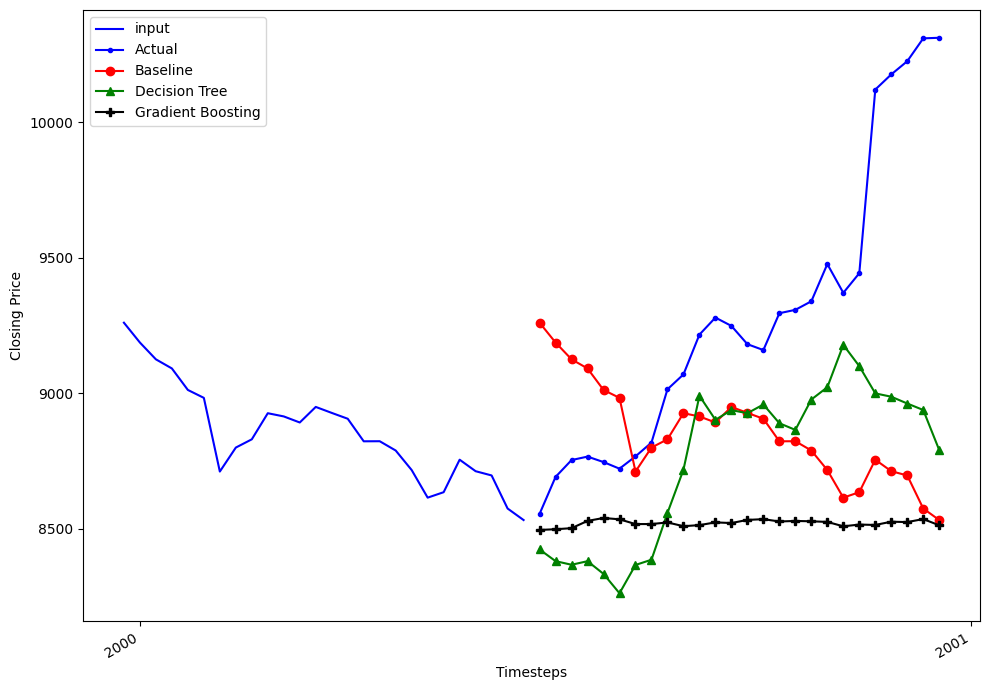

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(np.arange(0, 26, 1), X_test[1], 'b-', label='input')
ax.plot(np.arange(26, 52, 1), y_test[1], marker='.', color='blue', label='Actual')
ax.plot(np.arange(26, 52, 1), X_test[1], marker='o', color='red', label='Baseline')
ax.plot(np.arange(26, 52, 1), dt_seq_preds[1], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(26, 52, 1), gbr_seq_preds[1], marker='P', color='black', label='Gradient Boosting')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Closing Price')

plt.xticks(np.arange(1, 104, 52), np.arange(2000, 2002, 1))
plt.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()